# Movie Review Sentiment Analysis

Goal: Build a model that classifies movie reviews as positive or negative based on sentiment analysis.

### Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

### Downloading the IMDb Movie Reviews Dataset

In [3]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head(10) #Display first few rows

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
df.shape # 2 columns and 50000 rows/reviews

(50000, 2)

In [5]:
df.dtypes #check data types for columns

,0
review,object
sentiment,object


In [6]:
#Summary statistics for dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.isnull().sum() #check for missing values

,0
review,0
sentiment,0


In [8]:
# Checking if positive and negative sentiments class distribution is equal or not
df['sentiment'].value_counts() # This is a balanced dataset

,count
sentiment,
positive,25000
negative,25000


## Text Preprocessing

Converting text to **lowercase** can help to reduce redundancy of same words such as "Good" and "good" will be treated same. This helps to simplify tokenization and feature extraction which can improve the performance of NLP models. Removing HTML tags, punctuations and special characters will help to reduce unnecessary elements in our dataset and removing stop words like 'the', 'and', 'is' which have no meaning can be removed for improving performance of NLP models. Tokenization helps to break the text into subwords called tokens which can help the NLP models to understand the meaning of language. Since we want to preserve words to not change their meanings or sentiment for movie reviews, stemming and lemmatization is not required.

In [9]:
# Convert to lowercase
df['review'] = df['review'].str.lower()
print(df)

                                                  review sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production. <br /><br />the...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically there's a family where a little boy ...  negative
4      petter mattei's "love in the time of money" is...  positive
...                                                  ...       ...
49995  i thought this movie did a down right good job...  positive
49996  bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  i am a catholic taught in parochial elementary...  negative
49998  i'm going to have to disagree with the previou...  negative
49999  no one expects the star trek movies to be high...  negative

[50000 rows x 2 columns]


In [10]:
# Removing HTML tags since IMDb dataset has <br> tags and other HTML elements

import re #Regular Expression module

# The str method replaces the regular expression pattern that matches HTML tags with an empty string
df['review'] = df['review'].str.replace(r'<.*?>', '', regex=True)
print(df)

                                                  review sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production. the filming tec...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically there's a family where a little boy ...  negative
4      petter mattei's "love in the time of money" is...  positive
...                                                  ...       ...
49995  i thought this movie did a down right good job...  positive
49996  bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  i am a catholic taught in parochial elementary...  negative
49998  i'm going to have to disagree with the previou...  negative
49999  no one expects the star trek movies to be high...  negative

[50000 rows x 2 columns]


In [11]:
# Removing Punctuations and Special characters
df['review'] = df['review'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
print(df)

                                                  review sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production the filming tech...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically theres a family where a little boy j...  negative
4      petter matteis love in the time of money is a ...  positive
...                                                  ...       ...
49995  i thought this movie did a down right good job...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  i am a catholic taught in parochial elementary...  negative
49998  im going to have to disagree with the previous...  negative
49999  no one expects the star trek movies to be high...  negative

[50000 rows x 2 columns]


In [12]:
# Removing stopwords like 'the' 'and'

import nltk # Using NLTK library for stopwords
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # we can set the words in stopwords to english

"""
In this function, the text is a single movie review and text.split() will split the text into a list of words
and using a list comprehension, we can loop through each word in the splitted text and check if that word is not already in the predefined
stopwords list then we can add that word and join all those words back in sentence
"""
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

df['review'] = df['review'].apply(remove_stopwords)
print(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                  review sentiment
0      one reviewers mentioned watching 1 oz episode ...  positive
1      wonderful little production filming technique ...  positive
2      thought wonderful way spend time hot summer we...  positive
3      basically theres family little boy jake thinks...  negative
4      petter matteis love time money visually stunni...  positive
...                                                  ...       ...
49995  thought movie right good job wasnt creative or...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  catholic taught parochial elementary schools n...  negative
49998  im going disagree previous comment side maltin...  negative
49999  one expects star trek movies high art fans exp...  negative

[50000 rows x 2 columns]


In [13]:
# Tokenization
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('punkt')

def tokenize_review(review):
    return word_tokenize(review)

df['review_tokens'] = df['review'].apply(tokenize_review) #creating another column of word tokens
print(df)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                  review sentiment  \
0      one reviewers mentioned watching 1 oz episode ...  positive   
1      wonderful little production filming technique ...  positive   
2      thought wonderful way spend time hot summer we...  positive   
3      basically theres family little boy jake thinks...  negative   
4      petter matteis love time money visually stunni...  positive   
...                                                  ...       ...   
49995  thought movie right good job wasnt creative or...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  catholic taught parochial elementary schools n...  negative   
49998  im going disagree previous comment side maltin...  negative   
49999  one expects star trek movies high art fans exp...  negative   

                                           review_tokens  
0      [one, reviewers, mentioned, watching, 1, oz, e...  
1      [wonderful, little, production, fi

In [14]:
# for all the tokens in our tokenized reviews column, we join them into a single string
df['review_cleaned'] = [' '.join(tokens) for tokens in df['review_tokens']]

print(df)

                                                  review sentiment  \
0      one reviewers mentioned watching 1 oz episode ...  positive   
1      wonderful little production filming technique ...  positive   
2      thought wonderful way spend time hot summer we...  positive   
3      basically theres family little boy jake thinks...  negative   
4      petter matteis love time money visually stunni...  positive   
...                                                  ...       ...   
49995  thought movie right good job wasnt creative or...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  catholic taught parochial elementary schools n...  negative   
49998  im going disagree previous comment side maltin...  negative   
49999  one expects star trek movies high art fans exp...  negative   

                                           review_tokens  \
0      [one, reviewers, mentioned, watching, 1, oz, e...   
1      [wonderful, little, production, 

## Converting text to numerical values using TF-IDF Vectorizer

TF-IDF Vectorizer will convert text data into numerical values based on the importance of words in a document.

In [15]:
vectorizer = TfidfVectorizer()

# X will be our transformed features and y are the labels
X = vectorizer.fit_transform(df['review_cleaned'])
y = df['sentiment']

## Splitting Dataset for training and testing

Training set will be used to train the model and testing set will be used to evaluate how well the model performs on unseen data.

In [16]:
# Splitting into 80% training and 20% testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training a Naive Bayes Model

In [17]:
# Naive Bayes works well with binary classification sentiment analysis

model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

### The accuracy score tells us that against the actual correct sentiment, our model correctly predicted sentiment to 86.85% of the 10,000 reviews in the test set which is a solid score for a sentiment analysis system.



*   **Precision**: 88% of reviews were actually positive and 86% were actually negative
*   **Recall**: Our Naive Bayes model correctly found 86% of actual positives and 88% actual negatives

*  **F1-score**: combining the precision and recall scores of the Naive Bayes model, we can see for both classes(postive and negative) the F1-score is 87% which means there is well-balanced performance across both classes.

*  **Confusion matrix**: shows actual vs predicted values and Naive Bayes model correctly predicted 4357 actual negatives and 4328 actual positives.


Conclusion: The Naive Bayes model for movie reviews sentiment analysis is accurate to around 87% and it's balanced across both classes.





In [18]:
# Evaluating the Naive Bayes Model
y_pred = model_NB.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test,y_pred))

Accuracy: 0.8689
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      4961
    positive       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion matrix:
 [[4374  587]
 [ 724 4315]]


### Plotting the confusion matrix for Naive Bayes model

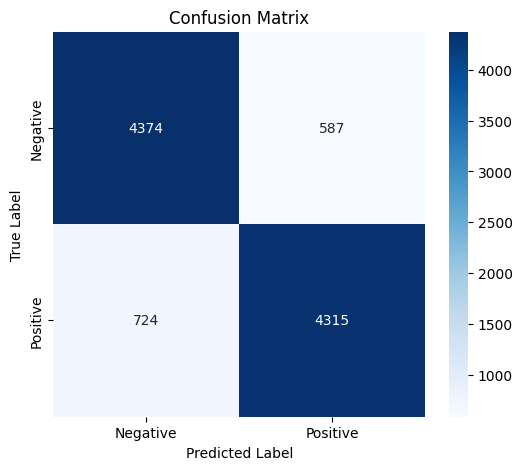

In [19]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Training a Logistic Regression Model

Using the same Split of training and testing dataset, we can see the Logistic Regression model performs better than the Naive Bayes model with accuracy score of 89% and better recall and F1-score and it also correctly identifies more positive reviews.

Why is this the case?



*   Naive Bayes assumes all words in the reviews are independent of each other whereas Logistic Regression does not make this independent assumption but it learns weights for each word and captures the slight differences in meanings of the words contributing if they are positive or negative so it processes complex patterns in our TF-IDF text data better.

*   Naive Bayes is simple and fast but not flexible as compared to Logistic Regression which is better suited for real world datasets like IMDb dataset.



*   Logistic Regression handles context better and adapts better to data

Conclusion: Logistic Regression performs better than Naive Bayes on IMDb sentiment analysis because it makes fewer assumptions, uses TF-IDF more effectively and captures word importance and word relationships much better.






In [20]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Evaluating the Logistic Regression Model
y_pred_lr = model_LR.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Accuracy: 0.897
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4961
    positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
 [[4379  582]
 [ 448 4591]]


### Plotting confusion matrix for Logistic Regression Model

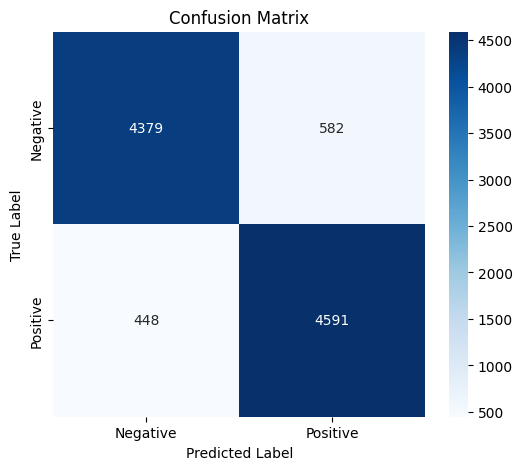

In [22]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
labels = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()